In [1]:
include("../src/QuantumDD/QuantumDD.jl")
using .QuantumDD, FFTW, Plots, Statistics

In [10]:
pulses = get_shaped_pulses("CDD XY8", 1.0, 6; pulse_duration=0.01)

for (i, p) in enumerate(pulses)
    println("Pulse $i: start=$(p.start), stop=$(p.stop), axis=$(p.axis)")
end

Pulse 1: start=-0.0040234375, stop=0.0059765625, axis=x
Pulse 2: start=-0.0020703125, stop=0.007929687500000001, axis=y
Pulse 3: start=-0.0001171875000000001, stop=0.009882812500000001, axis=x
Pulse 4: start=0.0018359375, stop=0.011835937500000001, axis=y
Pulse 5: start=0.0037890625, stop=0.013789062500000001, axis=y
Pulse 6: start=0.0057421875, stop=0.0157421875, axis=x
Pulse 7: start=0.0076953125, stop=0.0176953125, axis=y
Pulse 8: start=0.009648437499999999, stop=0.0196484375, axis=x
Pulse 9: start=0.011601562499999999, stop=0.0216015625, axis=x
Pulse 10: start=0.013554687499999999, stop=0.0235546875, axis=y
Pulse 11: start=0.015507812499999999, stop=0.0255078125, axis=x
Pulse 12: start=0.0174609375, stop=0.0274609375, axis=y
Pulse 13: start=0.0194140625, stop=0.0294140625, axis=y
Pulse 14: start=0.0213671875, stop=0.0313671875, axis=x
Pulse 15: start=0.0233203125, stop=0.0333203125, axis=y
Pulse 16: start=0.0252734375, stop=0.0352734375, axis=x
Pulse 17: start=0.0272265625, stop=0.

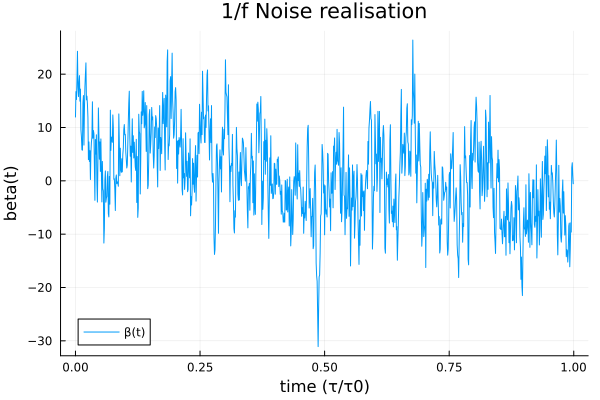

In [55]:
params = get_preset_params("1/f")
S_func = ω -> S(ω; :a => 0, :b => 1, :α => 1.0, :c => 0.0, :ω_c => Inf)
T= 1.0
dt = 1e-3
target_std = 1e-2
t_list, beta_t = generate_beta(S_func, T; dt = dt, target_std = target_std)
plot(t_list, beta_t, label="β(t)", xlabel="time (τ/τ0)", ylabel="beta(t)", title="1/f Noise realisation")


In [56]:
savefig("1_over_f_noise_realisation.png")

"c:\\Users\\vikra\\OneDrive\\Desktop\\project\\notebooks\\1_over_f_noise_realisation.png"

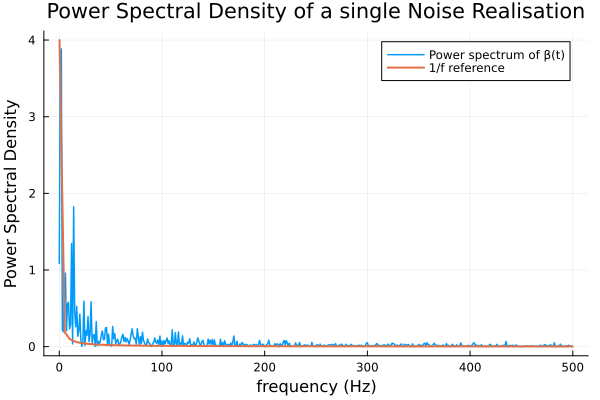

In [58]:
std(beta_t)
plt = plot_spectrum(beta_t, dt; log= false, label="Power spectrum of β(t)")
f=range(1/4,500, 100)
g(x)=1/x
plot!(plt, f, g.(f); label="1/f reference", xlabel="frequency (Hz)", ylabel="Power Spectral Density", lw=2, title="Power Spectral Density of a single Noise Realisation")
savefig("single_realisation_power_spectrum.png")
display(plt)

In [72]:
n_realizations = 1000
t_vec, β_tmp   = generate_beta(S_func, T; dt=dt, target_std=target_std)
N              = length(β_tmp)
fft_len        = div(N,2) + 1          # length of rfft output
psd_sum        = zeros(Float64, fft_len)  # accumulate power spectra

function one_sided_psd(β::Vector{Float64}, dt::Float64)
    N  = length(β)
    βf = rfft(β)                       # real FFT (length N/2+1)
    psd = abs2.(βf) .* (2*dt/N^2)      # scale so ∫PSD dω ≈ var
    psd[1] /= 2                        # DC component not doubled
    if iseven(N)
        psd[end] /= 2                  # Nyquist term (even-length correction)
    end
    return psd
end

for _ in 1:n_realizations
    _, β = generate_beta(S_func, T; dt=dt, target_std=target_std)
    psd_sum .+= one_sided_psd(β, dt)
end

psd_avg = psd_sum ./ n_realizations
freqs   = (0:fft_len-1) .* (1/(N*dt))     # frequency grid (Hz)

# --- reference 1/f line (scaled for eye-guidance) ---------------------------
ref = 1 ./ (freqs .+ 1e-6)              # avoid divide-by-zero at f=0

# --- plot -------------------------------------------------------------------
plot(freqs, psd_avg;
     xscale=:log10, yscale=:log10,
     xlabel="frequency (Hz)", ylabel="Power Spectral Density",
     label = "Average PSD ($n_realizations realisations)",
     linewidth=2)

plot!(freqs, ref; label="1/f reference", linewidth=2, color=:orange)
title!("Average PSD of β(t) — 1/f noise")
xlims!(1e-1, maximum(freqs))
savefig("average_power_spectrum.png")

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based xscale
└ @ Plots C:\Users\vikra\.julia\packages\Plots\MR7sb\src\utils.jl:106


"c:\\Users\\vikra\\OneDrive\\Desktop\\project\\notebooks\\average_power_spectrum.png"

In [66]:
using LinearAlgebra

In [71]:
scale = sum(psd_avg .* ref) / sum(ref .* ref)
ref_scaled = scale .* ref
mse      = mean((psd_avg .- ref_scaled).^2)
rel_err  = norm(psd_avg .- ref_scaled) / norm(ref_scaled)
log_mse  = mean((log10.(psd_avg) .- log10.(ref_scaled)).^2)

println(mse)
println(rel_err)
println(log_mse)

3.103551616441289e-7
1.0383622408117714
35.26111879881281


In [2]:
sequence = "HAHN"
T = 1.0
n_pulses = 10
pulse_duration = 1e-3

pulses = get_shaped_pulses(sequence, T, n_pulses; pulse_duration=pulse_duration, axis=:x)
plot_pulse_schedule(pulses,T; sequence="Hahn Echo")
savefig("Hahn_echo_pulse_schedule.png")

"c:\\Users\\vikra\\OneDrive\\Desktop\\project\\notebooks\\Hahn_echo_pulse_schedule.png"

In [3]:
sequence = "CPMG"
T = 1.0
n_pulse_list = [1, 2, 4, 8, 16, 32, 64]
pulse_duration = 1e-3
for n_pulses in n_pulse_list
    pulses = get_shaped_pulses(sequence, T, n_pulses; pulse_duration=pulse_duration, axis=:x)
    plot_pulse_schedule(pulses, T; sequence="CPMG with $n_pulses pulses")
    savefig("CPMG_pulse_schedule_$(n_pulses).png")
end



In [4]:
sequence = "CDD"
T = 1.0
level_list = [1,2,3,4,5,6]
pulse_duration = 1e-3
for level in level_list
    pulses = get_shaped_pulses(sequence, T, level; pulse_duration=pulse_duration, axis=:x)
    plot_pulse_schedule(pulses, T; sequence="CDD with level $level")
    savefig("CDD_pulse_schedule_level_$(level).png")
end

In [5]:
sequence = "UDD"
T = 1.0
n_pulse_list = [1, 2, 4, 8, 16, 32, 64]
pulse_duration = 1e-3

for n_pulses in n_pulse_list
    pulses = get_shaped_pulses(sequence, T, n_pulses; pulse_duration=pulse_duration, axis=:x)
    plot_pulse_schedule(pulses, T; sequence="UDD with $n_pulses pulses")
    savefig("UDD_pulse_schedule_$(n_pulses).png")
end

In [6]:
sequence = "PDD"
T = 1.0
n_pulse_list = [1, 2, 4, 8, 16, 32, 64]
pulse_duration = 1e-3
for n_pulses in n_pulse_list
    pulses = get_shaped_pulses(sequence, T, n_pulses; pulse_duration=pulse_duration, axis=:x)
    plot_pulse_schedule(pulses, T; sequence="PDD with $n_pulses pulses")
    savefig("PDD_pulse_schedule_$(n_pulses).png")
end


In [ ]:
sequence = "HAHN"
T        = 1.0
pulse_duration = 1e-3
pulses = get_shaped_pulses(sequence, T, 1; pulse_duration=pulse_duration, axis=:x)
pulse_times = [p.start + pulse_duration/2 for p in pulses]
sequence = "Hahn Echo"
plot_modulation(pulse_times, T; color=:red,
                    sequence="$sequence")
savefig("Hahn_echo_modulation.png")

"c:\\Users\\vikra\\OneDrive\\Desktop\\project\\notebooks\\Hahn_echo_modulation.png"

In [5]:
sequence = "CPMG"
T        = 1.0
pulse_duration = 1e-3
n_pulse_list   = [1, 2, 4, 8, 16, 32, 64]

for N in n_pulse_list
    pulses = get_shaped_pulses(sequence, T, N; pulse_duration=pulse_duration, axis=:x)
    # Use pulse centres for flips:
    pulse_times = [p.start + pulse_duration/2 for p in pulses]

    plot_modulation(pulse_times, T; color=:red,
                    sequence="$sequence with $N pulses")
    savefig("CPMG_modulation_$(N).png")
end


In [6]:
sequence = "UDD"
T        = 1.0
pulse_duration = 1e-3
n_pulse_list   = [1, 2, 4, 8, 16, 32, 64]

for N in n_pulse_list
    pulses = get_shaped_pulses(sequence, T, N; pulse_duration=pulse_duration, axis=:x)
    # Use pulse centres for flips:
    pulse_times = [p.start + pulse_duration/2 for p in pulses]

    plot_modulation(pulse_times, T; color=:red,
                    sequence="$sequence with $N pulses")
    savefig("UDD_modulation_$(N).png")
end


In [7]:
sequence = "PDD"
T        = 1.0
pulse_duration = 1e-3
n_pulse_list   = [1, 2, 4, 8, 16, 32, 64]

for N in n_pulse_list
    pulses = get_shaped_pulses(sequence, T, N; pulse_duration=pulse_duration, axis=:x)
    # Use pulse centres for flips:
    pulse_times = [p.start + pulse_duration/2 for p in pulses]

    plot_modulation(pulse_times, T; color=:red,
                    sequence="$sequence with $N pulses")
    savefig("PDD_modulation_$(N).png")
end


In [2]:
sequence = "CDD"
T        = 1.0
pulse_duration = 1e-3
levels_list   = [1, 2, 3, 4, 5, 6]

for level in levels_list
    pulses = get_shaped_pulses(sequence, T, level; pulse_duration=pulse_duration, axis=:x)
    # Use pulse centres for flips:
    pulse_times = [p.start + pulse_duration/2 for p in pulses]

    plot_modulation(pulse_times, T; color=:red,
                    sequence="$sequence with $level pulses")
    savefig("CDD_modulation_level_$(level).png")
end


In [1]:
using CSV
using DataFrames
using Plots

In [25]:
using CSV, DataFrames

base = joinpath("..", "data", "CPMG_1_over_f_data")
function read_fit_params(filepath::String)
    values = CSV.read(filepath, DataFrame; header=false) |> x -> x[1, :]
    return (λ=values[1], β=values[2], A=values[3])
end


df_100 = CSV.read(joinpath(base, "CPMG_1_over_f_0100_pulses_data_20250613_0842.csv"), DataFrame)
df_200 = CSV.read(joinpath(base, "CPMG_1_over_f_0200_pulses_data_20250613_0906.csv"), DataFrame)
df_400 = CSV.read(joinpath(base, "CPMG_1_over_f_0400_pulses_data_20250613_1031.csv"), DataFrame)
df_600 = CSV.read(joinpath(base, "CPMG_1_over_f_0600_pulses_data_20250613_1458.csv"), DataFrame)
df_800 = CSV.read(joinpath(base, "CPMG_1_over_f_0800_pulses_data_20250614_0453.csv"), DataFrame)
df_fid = CSV.read(joinpath(base,"CPMG_1_over_f_FID_data_20250615_2213.csv"), DataFrame)
rename!(df_100, [:t, :sim, :fit])
rename!(df_200, [:t, :sim, :fit])
rename!(df_400, [:t, :sim, :fit])
rename!(df_600, [:t, :sim, :fit])
rename!(df_800, [:t, :sim, :fit])
rename!(df_fid, [:t, :sim, :fit])



1000×3 DataFrame
  Row │ t        sim       fit      
      │ Float64  Float64   Float64  
──────┼─────────────────────────────
    1 │   0.001  0.999875  0.99978
    2 │   0.002  0.999527  0.9993
    3 │   0.003  0.999009  0.998624
    4 │   0.004  0.998321  0.997778
    5 │   0.005  0.997447  0.996778
    6 │   0.006  0.996426  0.995636
    7 │   0.007  0.995278  0.994362
    8 │   0.008  0.994015  0.992965
  ⋮   │    ⋮        ⋮         ⋮
  994 │   0.994  0.491578  0.502818
  995 │   0.995  0.491117  0.502818
  996 │   0.996  0.49059   0.502818
  997 │   0.997  0.490134  0.502818
  998 │   0.998  0.489914  0.502818
  999 │   0.999  0.489645  0.502818
 1000 │   1.0    0.489058  0.502818
                    985 rows omitted

In [26]:
fit_params_100 = CSV.read(joinpath(base,"CPMG_1_over_f_0100_pulses_fitparams_20250613_0842.csv"), DataFrame;header=false)
fit_params_200 = CSV.read(joinpath(base,"CPMG_1_over_f_0200_pulses_fitparams_20250613_0906.csv"), DataFrame;header=false)
fit_params_400 = CSV.read(joinpath(base,"CPMG_1_over_f_0400_pulses_fitparams_20250613_1031.csv"), DataFrame;header=false)
fit_params_600 = CSV.read(joinpath(base,"CPMG_1_over_f_0600_pulses_fitparams_20250613_1458.csv"), DataFrame;header=false)
fit_params_800 = CSV.read(joinpath(base,"CPMG_1_over_f_0800_pulses_fitparams_20250614_0453.csv"), DataFrame;header=false)
fit_params_fid = CSV.read(joinpath(base,"CPMG_1_over_f_fitparams_20250615_2030.csv"), DataFrame;header=false)
rename!(fit_params_100, [:λ, :β, :A])
rename!(fit_params_200, [:λ, :β, :A])
rename!(fit_params_400, [:λ, :β, :A])
rename!(fit_params_600, [:λ, :β, :A])
rename!(fit_params_800, [:λ, :β, :A])
rename!(fit_params_fid, [:λ, :β, :A])

1×3 DataFrame
 Row │ λ        β        A        
     │ Float64  Float64  Float64  
─────┼────────────────────────────
   1 │ 9.79752  1.66955  0.502825

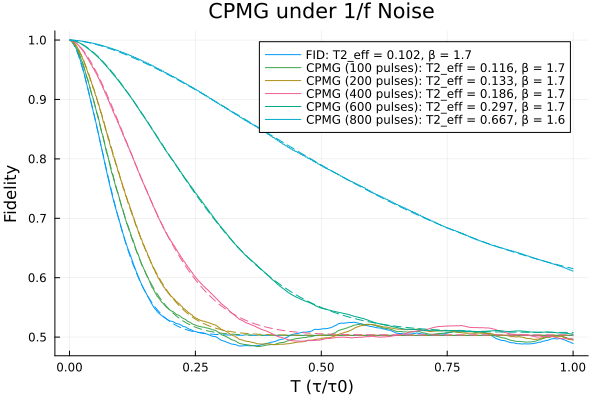

In [37]:
using Printf
plt = plot(title="CPMG under 1/f Noise", xlabel="T (τ/τ0)", ylabel="Fidelity", legend=:topright)

plot!(df_fid.t, df_fid.sim; label="FID: T2_eff = $(@sprintf("%.3g",1/fit_params_fid.λ[1])), β = $(@sprintf("%.2g",fit_params_fid.β[1]))")
c = plt.series_list[end].plotattributes[:seriescolor]
plot!(df_fid.t, df_fid.fit; label=false, color=c, linestyle=:dash)

plot!(df_100.t, df_100.sim; label="CPMG (100 pulses): T2_eff = $(@sprintf("%.3g",1/fit_params_100.λ[1])), β = $(@sprintf("%.2g",fit_params_100.β[1]))")
c = plt.series_list[end].plotattributes[:seriescolor]
plot!(df_100.t, df_100.fit; label=false, color = c, linestyle=:dash)

plot!(df_200.t, df_200.sim; label="CPMG (200 pulses): T2_eff = $(@sprintf("%.3g",1/fit_params_200.λ[1])), β = $(@sprintf("%.2g",fit_params_200.β[1]))")
c = plt.series_list[end].plotattributes[:seriescolor]
plot!(df_200.t, df_200.fit; label=false, color = c, linestyle=:dash)

plot!(df_400.t, df_400.sim; label="CPMG (400 pulses): T2_eff = $(@sprintf("%.3g",1/fit_params_400.λ[1])), β = $(@sprintf("%.2g",fit_params_400.β[1]))")
c = plt.series_list[end].plotattributes[:seriescolor]
plot!(df_400.t, df_400.fit; label=false, color = c, linestyle=:dash)

plot!(df_600.t, df_600.sim; label="CPMG (600 pulses): T2_eff = $(@sprintf("%.3g",1/fit_params_600.λ[1])), β = $(@sprintf("%.2g",fit_params_600.β[1]))")
c = plt.series_list[end].plotattributes[:seriescolor]
plot!(df_600.t, df_600.fit; label=false, color = c, linestyle=:dash)

plot!(df_800.t, df_800.sim; label="CPMG (800 pulses): T2_eff = $(@sprintf("%.3g",1/fit_params_800.λ[1])), β = $(@sprintf("%.2g",fit_params_800.β[1]))")
c = plt.series_list[end].plotattributes[:seriescolor]
plot!(df_800.t, df_800.fit; label=false, color = c, linestyle=:dash)


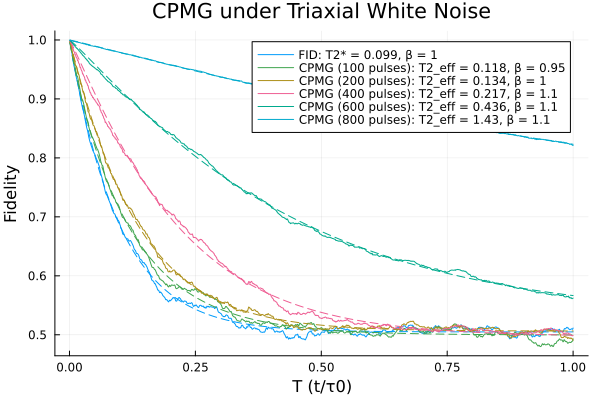

In [38]:
using CSV, DataFrames, Plots, Printf

base = joinpath("..", "data", "CPMG_white_white")

# Read data CSVs
df_100 = CSV.read(joinpath(base, "CPMG_white_white_0100_pulses_data_20250613_1201.csv"), DataFrame)
df_200 = CSV.read(joinpath(base, "CPMG_white_white_0200_pulses_data_20250613_1246.csv"), DataFrame)
df_400 = CSV.read(joinpath(base, "CPMG_white_white_0400_pulses_data_20250613_1530.csv"), DataFrame)
df_600 = CSV.read(joinpath(base, "CPMG_white_white_0600_pulses_data_20250613_2112.csv"), DataFrame)
df_800 = CSV.read(joinpath(base, "CPMG_white_white_0800_pulses_data_20250614_0453.csv"), DataFrame)
df_fid = CSV.read(joinpath(base, "CPMG_white_white_FID_data_20250616_0119.csv"), DataFrame)

# Rename columns
rename!(df_100, [:t, :sim, :fit])
rename!(df_200, [:t, :sim, :fit])
rename!(df_400, [:t, :sim, :fit])
rename!(df_600, [:t, :sim, :fit])
rename!(df_800, [:t, :sim, :fit])
rename!(df_fid, [:t, :sim, :fit])

# Read fitparams CSVs
fit_params_100 = CSV.read(joinpath(base, "CPMG_white_white_0100_pulses_fitparams_20250613_1201.csv"), DataFrame; header=false)
fit_params_200 = CSV.read(joinpath(base, "CPMG_white_white_0200_pulses_fitparams_20250613_1246.csv"), DataFrame; header=false)
fit_params_400 = CSV.read(joinpath(base, "CPMG_white_white_0400_pulses_fitparams_20250613_1530.csv"), DataFrame; header=false)
fit_params_600 = CSV.read(joinpath(base, "CPMG_white_white_0600_pulses_fitparams_20250613_2112.csv"), DataFrame; header=false)
fit_params_800 = CSV.read(joinpath(base, "CPMG_white_white_0800_pulses_fitparams_20250614_0453.csv"), DataFrame; header=false)
fit_params_fid = CSV.read(joinpath(base, "CPMG_white_white_FID_fitparams_20250616_0119.csv"), DataFrame; header=false)

# Rename fit columns
rename!(fit_params_100, [:λ, :β, :A])
rename!(fit_params_200, [:λ, :β, :A])
rename!(fit_params_400, [:λ, :β, :A])
rename!(fit_params_600, [:λ, :β, :A])
rename!(fit_params_800, [:λ, :β, :A])
rename!(fit_params_fid, [:λ, :β, :A])

# Plot
plt = plot(title="CPMG under Triaxial White Noise", xlabel="T (t/τ0)", ylabel="Fidelity", legend=:topright)

plot!(df_fid.t, df_fid.sim; label="FID: T2* = $(@sprintf("%.3g", 1 / fit_params_fid.λ[1])), β = $(@sprintf("%.2g", fit_params_fid.β[1]))")
c = plt.series_list[end].plotattributes[:seriescolor]
plot!(df_fid.t, df_fid.fit; label=false, color=c, linestyle=:dash)

plot!(df_100.t, df_100.sim; label="CPMG (100 pulses): T2_eff = $(@sprintf("%.3g", 1 / fit_params_100.λ[1])), β = $(@sprintf("%.2g", fit_params_100.β[1]))")
c = plt.series_list[end].plotattributes[:seriescolor]
plot!(df_100.t, df_100.fit; label=false, color=c, linestyle=:dash)

plot!(df_200.t, df_200.sim; label="CPMG (200 pulses): T2_eff = $(@sprintf("%.3g", 1 / fit_params_200.λ[1])), β = $(@sprintf("%.2g", fit_params_200.β[1]))")
c = plt.series_list[end].plotattributes[:seriescolor]
plot!(df_200.t, df_200.fit; label=false, color=c, linestyle=:dash)

plot!(df_400.t, df_400.sim; label="CPMG (400 pulses): T2_eff = $(@sprintf("%.3g", 1 / fit_params_400.λ[1])), β = $(@sprintf("%.2g", fit_params_400.β[1]))")
c = plt.series_list[end].plotattributes[:seriescolor]
plot!(df_400.t, df_400.fit; label=false, color=c, linestyle=:dash)

plot!(df_600.t, df_600.sim; label="CPMG (600 pulses): T2_eff = $(@sprintf("%.3g", 1 / fit_params_600.λ[1])), β = $(@sprintf("%.2g", fit_params_600.β[1]))")
c = plt.series_list[end].plotattributes[:seriescolor]
plot!(df_600.t, df_600.fit; label=false, color=c, linestyle=:dash)

plot!(df_800.t, df_800.sim; label="CPMG (800 pulses): T2_eff = $(@sprintf("%.3g", 1 / fit_params_800.λ[1])), β = $(@sprintf("%.2g", fit_params_800.β[1]))")
c = plt.series_list[end].plotattributes[:seriescolor]
plot!(df_800.t, df_800.fit; label=false, color=c, linestyle=:dash)

display(plt)


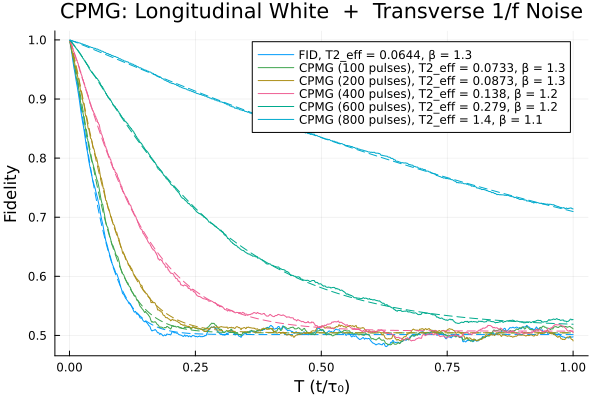

In [39]:
using CSV, DataFrames, Plots, Printf

# ------------------------------------------------------------------
# Folder that contains all the CSVs shown in your screenshot
base = joinpath("..", "data", "CPMG_white_1_over_f")

# Convenience helpers ------------------------------------------------
load_data(fname)   = rename!(CSV.read(joinpath(base, fname),  DataFrame), [:t, :sim, :fit])
load_params(fname) = rename!(CSV.read(joinpath(base, fname), DataFrame; header=false),
                             [:λ, :β, :A])

# ------------------------------------------------------------------
# 1.  Time-series fidelity traces
df_100 = load_data("CPMG_white_1_over_f_0100_pulses_data_20250613_1154.csv")
df_200 = load_data("CPMG_white_1_over_f_0200_pulses_data_20250613_1240.csv")
df_400 = load_data("CPMG_white_1_over_f_0400_pulses_data_20250613_1527.csv")
df_600 = load_data("CPMG_white_1_over_f_0600_pulses_data_20250613_2115.csv")
df_800 = load_data("CPMG_white_1_over_f_0800_pulses_data_20250614_0507.csv")
df_fid = load_data("CPMG_white_1_over_f_FID_data_20250616_0135.csv")

# 2.  Corresponding fit parameters (λ, β, A)
fit_100 = load_params("CPMG_white_1_over_f_0100_pulses_fitparams_20250613_1154.csv")
fit_200 = load_params("CPMG_white_1_over_f_0200_pulses_fitparams_20250613_1240.csv")
fit_400 = load_params("CPMG_white_1_over_f_0400_pulses_fitparams_20250613_1527.csv")
fit_600 = load_params("CPMG_white_1_over_f_0600_pulses_fitparams_20250613_2115.csv")
fit_800 = load_params("CPMG_white_1_over_f_0800_pulses_fitparams_20250614_0507.csv")
fit_fid = load_params("CPMG_white_1_over_f_FID_fitparams_20250616_0135.csv")

# ------------------------------------------------------------------
# Plot utility: add simulated & fitted curves with shared colour
function add_trace!(plt, df, fit, label_prefix)
    label = @sprintf("%s, T2_eff = %.3g, β = %.2g", label_prefix, 1/fit.λ[1], fit.β[1])
    plot!(plt, df.t, df.sim; label)               # solid line (simulation)
    colour = plt.series_list[end].plotattributes[:seriescolor]
    plot!(plt, df.t, df.fit; label=false, color=colour, linestyle=:dash)  # dashed (fit)
end

# ------------------------------------------------------------------
plt = plot(title = "CPMG: Longitudinal White  +  Transverse 1/f Noise",
           xlabel = "T (t/τ₀)", ylabel = "Fidelity", legend = :topright)

add_trace!(plt, df_fid,  fit_fid,  "FID")
add_trace!(plt, df_100,  fit_100,  "CPMG (100 pulses)")
add_trace!(plt, df_200,  fit_200,  "CPMG (200 pulses)")
add_trace!(plt, df_400,  fit_400,  "CPMG (400 pulses)")
add_trace!(plt, df_600,  fit_600,  "CPMG (600 pulses)")
add_trace!(plt, df_800,  fit_800,  "CPMG (800 pulses)")

display(plt)


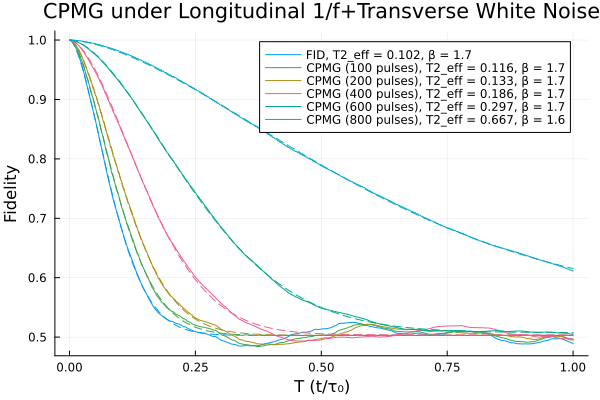

In [3]:
using CSV, DataFrames, Plots, Printf

# ------------------------------------------------------------------
# Folder that contains all the CSVs
base = joinpath("..", "data", "CPMG_1_over_f_white")

# Convenience helpers
load_data(fname) = rename!(CSV.read(joinpath(base, fname), DataFrame), [:t, :sim, :fit])
load_params(fname) = rename!(CSV.read(joinpath(base, fname), DataFrame; header=false), [:λ, :β, :A])

# ------------------------------------------------------------------
# 1. Time-series fidelity traces
df_100 = load_data("CPMG_1_over_f_white_0100_pulses_data_20250614_1953.csv")
df_200 = load_data("CPMG_1_over_f_white_0200_pulses_data_20250614_2014.csv")
df_400 = load_data("CPMG_1_over_f_white_0400_pulses_data_20250614_2147.csv")
df_600 = load_data("CPMG_1_over_f_white_0600_pulses_data_20250615_0120.csv")
df_800 = load_data("CPMG_1_over_f_white_0800_pulses_data_20250615_1312.csv")
df_fid = load_data("CPMG_1_over_f_white_FID_data_20250616_0226.csv")

# 2. Corresponding fit parameters (λ, β, A)
fit_100 = load_params("CPMG_1_over_f_white_0100_pulses_fitparams_20250614_1953.csv")
fit_200 = load_params("CPMG_1_over_f_white_0200_pulses_fitparams_20250614_2014.csv")
fit_400 = load_params("CPMG_1_over_f_white_0400_pulses_fitparams_20250614_2147.csv")
fit_600 = load_params("CPMG_1_over_f_white_0600_pulses_fitparams_20250615_0120.csv")
fit_800 = load_params("CPMG_1_over_f_white_0800_pulses_fitparams_20250615_1312.csv")
fit_fid = load_params("CPMG_1_over_f_white_FID_fitparams_20250616_0226.csv")

# ------------------------------------------------------------------
# Plot utility: add simulated & fitted curves with shared colour
function add_trace!(plt, df, fit, label_prefix)
    label = @sprintf("%s, T2_eff = %.3g, β = %.2g", label_prefix, 1/fit.λ[1], fit.β[1])
    plot!(plt, df.t, df.sim; label)
    color = plt.series_list[end].plotattributes[:seriescolor]
    plot!(plt, df.t, df.fit; label=false, color=color, linestyle=:dash)
end

# ------------------------------------------------------------------
plt = plot(
    title = "CPMG under Longitudinal 1/f+Transverse White Noise",
    xlabel = "T (t/τ₀)",
    ylabel = "Fidelity",
    legend = :topright
)

add_trace!(plt, df_fid, fit_fid, "FID")
add_trace!(plt, df_100, fit_100, "CPMG (100 pulses)")
add_trace!(plt, df_200, fit_200, "CPMG (200 pulses)")
add_trace!(plt, df_400, fit_400, "CPMG (400 pulses)")
add_trace!(plt, df_600, fit_600, "CPMG (600 pulses)")
add_trace!(plt, df_800, fit_800, "CPMG (800 pulses)")

display(plt)


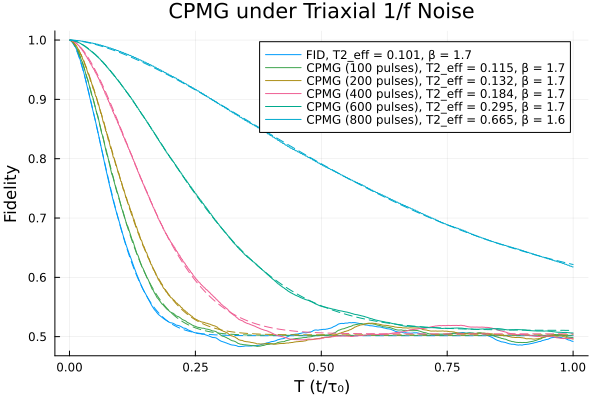

In [5]:
using CSV, DataFrames, Plots, Printf

# ------------------------------------------------------------------
# Folder that contains all the CSVs
base = joinpath("..", "data", "CPMG_1_over_f_1_over_f")

# Convenience helpers
load_data(fname) = rename!(CSV.read(joinpath(base, fname), DataFrame), [:t, :sim, :fit])
load_params(fname) = rename!(CSV.read(joinpath(base, fname), DataFrame; header=false), [:λ, :β, :A])

# ------------------------------------------------------------------
# 1. Time-series fidelity traces
df_100 = load_data("CPMG_1_over_f_1_over_f_0100_pulses_data_20250614_1953.csv")
df_200 = load_data("CPMG_1_over_f_1_over_f_0200_pulses_data_20250614_2015.csv")
df_400 = load_data("CPMG_1_over_f_1_over_f_0400_pulses_data_20250614_2151.csv")
df_600 = load_data("CPMG_1_over_f_1_over_f_0600_pulses_data_20250615_0138.csv")
df_800 = load_data("CPMG_1_over_f_1_over_f_0800_pulses_data_20250615_1317.csv")
df_fid = load_data("CPMG_1_over_f_1_over_f_FID_data_20250616_0235.csv")

# 2. Corresponding fit parameters (λ, β, A)
fit_100 = load_params("CPMG_1_over_f_1_over_f_0100_pulses_fitparams_20250614_1953.csv")
fit_200 = load_params("CPMG_1_over_f_1_over_f_0200_pulses_fitparams_20250614_2015.csv")
fit_400 = load_params("CPMG_1_over_f_1_over_f_0400_pulses_fitparams_20250614_2151.csv")
fit_600 = load_params("CPMG_1_over_f_1_over_f_0600_pulses_fitparams_20250615_0138.csv")
fit_800 = load_params("CPMG_1_over_f_1_over_f_0800_pulses_fitparams_20250615_1317.csv")
fit_fid = load_params("CPMG_1_over_f_1_over_f_FID_fitparams_20250616_0235.csv")

# ------------------------------------------------------------------
# Plot utility: add simulated & fitted curves with shared colour
function add_trace!(plt, df, fit, label_prefix)
    label = @sprintf("%s, T2_eff = %.3g, β = %.2g", label_prefix, 1/fit.λ[1], fit.β[1])
    plot!(plt, df.t, df.sim; label)
    color = plt.series_list[end].plotattributes[:seriescolor]
    plot!(plt, df.t, df.fit; label=false, color=color, linestyle=:dash)
end

# ------------------------------------------------------------------
plt = plot(
    title = "CPMG under Triaxial 1/f Noise",
    xlabel = "T (t/τ₀)",
    ylabel = "Fidelity",
    legend = :topright
)

add_trace!(plt, df_fid, fit_fid, "FID")
add_trace!(plt, df_100, fit_100, "CPMG (100 pulses)")
add_trace!(plt, df_200, fit_200, "CPMG (200 pulses)")
add_trace!(plt, df_400, fit_400, "CPMG (400 pulses)")
add_trace!(plt, df_600, fit_600, "CPMG (600 pulses)")
add_trace!(plt, df_800, fit_800, "CPMG (800 pulses)")

display(plt)


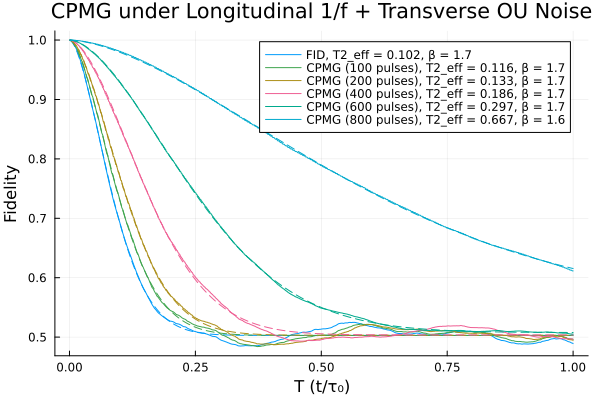

In [6]:
using CSV, DataFrames, Plots, Printf

# ------------------------------------------------------------------
# Folder that contains the CSV files
base = joinpath("..", "data", "CPMG_1_over_f_OU")

# Helpers for loading
load_data(fname) = rename!(CSV.read(joinpath(base, fname), DataFrame), [:t, :sim, :fit])
load_params(fname) = rename!(CSV.read(joinpath(base, fname), DataFrame; header=false), [:λ, :β, :A])

# ------------------------------------------------------------------
# Fidelity data traces
df_100 = load_data("CPMG_1_over_f_OU_0100_pulses_data_20250614_1955.csv")
df_200 = load_data("CPMG_1_over_f_OU_0200_pulses_data_20250614_2017.csv")
df_400 = load_data("CPMG_1_over_f_OU_0400_pulses_data_20250614_2151.csv")
df_600 = load_data("CPMG_1_over_f_OU_0600_pulses_data_20250615_0131.csv")
df_800 = load_data("CPMG_1_over_f_OU_0800_pulses_data_20250615_1316.csv")
df_fid = load_data("CPMG_1_over_f_OU_FID_data_20250616_0241.csv")

# Fit params
fit_100 = load_params("CPMG_1_over_f_OU_0100_pulses_fitparams_20250614_1955.csv")
fit_200 = load_params("CPMG_1_over_f_OU_0200_pulses_fitparams_20250614_2017.csv")
fit_400 = load_params("CPMG_1_over_f_OU_0400_pulses_fitparams_20250614_2151.csv")
fit_600 = load_params("CPMG_1_over_f_OU_0600_pulses_fitparams_20250615_0131.csv")
fit_800 = load_params("CPMG_1_over_f_OU_0800_pulses_fitparams_20250615_1316.csv")
fit_fid = load_params("CPMG_1_over_f_OU_FID_fitparams_20250616_0241.csv")

# ------------------------------------------------------------------
# Plotting helper
function add_trace!(plt, df, fit, label_prefix)
    label = @sprintf("%s, T2_eff = %.3g, β = %.2g", label_prefix, 1/fit.λ[1], fit.β[1])
    plot!(plt, df.t, df.sim; label)
    color = plt.series_list[end].plotattributes[:seriescolor]
    plot!(plt, df.t, df.fit; label=false, color=color, linestyle=:dash)
end

# ------------------------------------------------------------------
plt = plot(
    title = "CPMG under Longitudinal 1/f + Transverse OU Noise",
    xlabel = "T (t/τ₀)",
    ylabel = "Fidelity",
    legend = :topright
)

add_trace!(plt, df_fid, fit_fid, "FID")
add_trace!(plt, df_100, fit_100, "CPMG (100 pulses)")
add_trace!(plt, df_200, fit_200, "CPMG (200 pulses)")
add_trace!(plt, df_400, fit_400, "CPMG (400 pulses)")
add_trace!(plt, df_600, fit_600, "CPMG (600 pulses)")
add_trace!(plt, df_800, fit_800, "CPMG (800 pulses)")

display(plt)


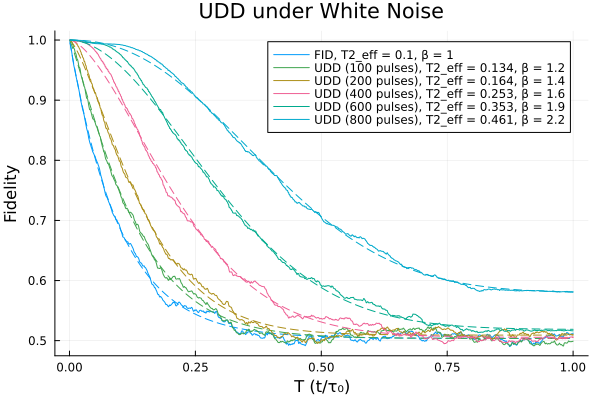

In [ ]:
using CSV, DataFrames, Plots, Printf

# ------------------------------------------------------------------
# Folder that contains the CSV files
base = joinpath("..", "data", "UDD_white")

# Helpers for loading
load_data(fname) = rename!(CSV.read(joinpath(base, fname), DataFrame), [:t, :sim, :fit])
load_params(fname) = rename!(CSV.read(joinpath(base, fname), DataFrame; header=false), [:λ, :β, :A])

# ------------------------------------------------------------------
# Fidelity data traces
df_100 = load_data("UDD_white_0100_pulses_data_20250613_0843.csv")
df_200 = load_data("UDD_white_0200_pulses_data_20250613_0910.csv")
df_400 = load_data("UDD_white_0400_pulses_data_20250613_1033.csv")
df_600 = load_data("UDD_white_0600_pulses_data_20250613_1442.csv")
df_800 = load_data("UDD_white_0800_pulses_data_20250614_0441.csv")
df_fid = load_data("UDD_white_FID_data_20250616_1916.csv")

# Fit params
fit_100 = load_params("UDD_white_0100_pulses_fitparams_20250613_0843.csv")
fit_200 = load_params("UDD_white_0200_pulses_fitparams_20250613_0910.csv")
fit_400 = load_params("UDD_white_0400_pulses_fitparams_20250613_1033.csv")
fit_600 = load_params("UDD_white_0600_pulses_fitparams_20250613_1442.csv")
fit_800 = load_params("UDD_white_0800_pulses_fitparams_20250614_0441.csv")
fit_fid = load_params("UDD_white_FID_fitparams_20250616_1916.csv")

# ------------------------------------------------------------------
# Plotting helper
function add_trace!(plt, df, fit, label_prefix)
    label = @sprintf("%s, T2_eff = %.3g, β = %.2g", label_prefix, 1/fit.λ[1], fit.β[1])
    plot!(plt, df.t, df.sim; label)
    color = plt.series_list[end].plotattributes[:seriescolor]
    plot!(plt, df.t, df.fit; label=false, color=color, linestyle=:dash)
end

# ------------------------------------------------------------------
plt = plot(
    title = "UDD under White Noise",
    xlabel = "T (t/τ₀)",
    ylabel = "Fidelity",
    legend = :topright
)

add_trace!(plt, df_fid, fit_fid, "FID")
add_trace!(plt, df_100, fit_100, "UDD (100 pulses)")
add_trace!(plt, df_200, fit_200, "UDD (200 pulses)")
add_trace!(plt, df_400, fit_400, "UDD (400 pulses)")
add_trace!(plt, df_600, fit_600, "UDD (600 pulses)")
add_trace!(plt, df_800, fit_800, "UDD (800 pulses)")

display(plt)


In [2]:
savefig("UDD_white_800.png")

"c:\\Users\\vikra\\OneDrive\\Desktop\\project\\notebooks\\UDD_white_800.png"

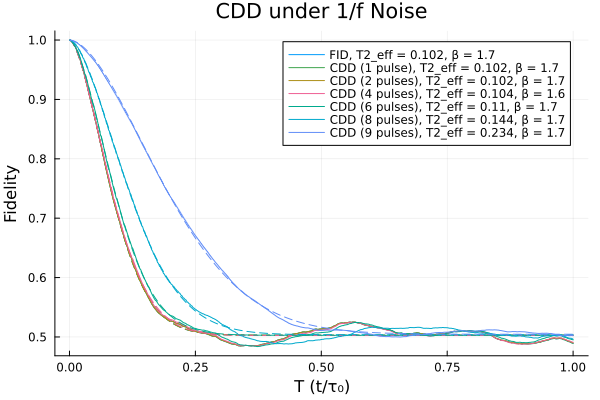

"c:\\Users\\vikra\\OneDrive\\Desktop\\project\\notebooks\\CDD_1_pver_f_9.png"

In [3]:
using CSV, DataFrames, Plots, Printf

# ------------------------------------------------------------------
# Folder that contains the CSV files
base = joinpath("..", "data", "CDD_1_over_f")

# Helpers for loading
load_data(fname) = rename!(CSV.read(joinpath(base, fname), DataFrame), [:t, :sim, :fit])
load_params(fname) = rename!(CSV.read(joinpath(base, fname), DataFrame; header=false), [:λ, :β, :A])

# ------------------------------------------------------------------
# Fidelity data traces
df_1 = load_data("CDD_1_over_f_1_pulses_data_20250615_0000.csv")
df_2 = load_data("CDD_1_over_f_2_pulses_data_20250615_0001.csv")
df_4 = load_data("CDD_1_over_f_4_pulses_data_20250615_0001.csv")
df_6 = load_data("CDD_1_over_f_6_pulses_data_20250615_0006.csv")
df_8 = load_data("CDD_1_over_f_8_pulses_data_20250615_0102.csv")
df_9 = load_data("CDD_1_over_f_9_pulses_data_20250615_1040.csv")
df_fid = load_data("CDD_1_over_f_FID_data_20250616_1943.csv")

# Fit params
fit_1 = load_params("CDD_1_over_f_1_pulses_fitparams_20250615_0000.csv")
fit_2 = load_params("CDD_1_over_f_2_pulses_fitparams_20250615_0001.csv")
fit_4 = load_params("CDD_1_over_f_4_pulses_fitparams_20250615_0001.csv")
fit_6 = load_params("CDD_1_over_f_6_pulses_fitparams_20250615_0006.csv")
fit_8 = load_params("CDD_1_over_f_8_pulses_fitparams_20250615_0102.csv")
fit_9 = load_params("CDD_1_over_f_9_pulses_fitparams_20250615_1040.csv")
fit_fid = load_params("CDD_1_over_f_FID_fitparams_20250616_1943.csv")

# ------------------------------------------------------------------
# Plotting helper
function add_trace!(plt, df, fit, label_prefix)
    label = @sprintf("%s, T2_eff = %.3g, β = %.2g", label_prefix, 1/fit.λ[1], fit.β[1])
    plot!(plt, df.t, df.sim; label)
    color = plt.series_list[end].plotattributes[:seriescolor]
    plot!(plt, df.t, df.fit; label=false, color=color, linestyle=:dash)
end

# ------------------------------------------------------------------
plt = plot(
    title = "CDD under 1/f Noise",
    xlabel = "T (t/τ₀)",
    ylabel = "Fidelity",
    legend = :topright
)

add_trace!(plt, df_fid, fit_fid, "FID")
add_trace!(plt, df_1, fit_1, "CDD (1 pulse)")
add_trace!(plt, df_2, fit_2, "CDD (2 pulses)")
add_trace!(plt, df_4, fit_4, "CDD (4 pulses)")
add_trace!(plt, df_6, fit_6, "CDD (6 pulses)")
add_trace!(plt, df_8, fit_8, "CDD (8 pulses)")
add_trace!(plt, df_9, fit_9, "CDD (9 pulses)")

display(plt)

savefig("CDD_1_pver_f_9.png")

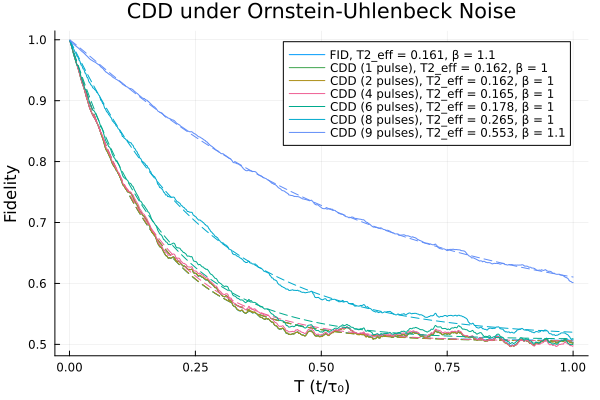

"c:\\Users\\vikra\\OneDrive\\Desktop\\project\\notebooks\\CDD_ou_9.png"

In [4]:
using CSV, DataFrames, Plots, Printf

# ------------------------------------------------------------------
# Folder that contains the CSV files
base = joinpath("..", "data", "CDD_OU")

# Helpers for loading
load_data(fname) = rename!(CSV.read(joinpath(base, fname), DataFrame), [:t, :sim, :fit])
load_params(fname) = rename!(CSV.read(joinpath(base, fname), DataFrame; header=false), [:λ, :β, :A])

# ------------------------------------------------------------------
# Fidelity data traces
df_1 = load_data("CDD_OU_1_pulses_data_20250615_0012.csv")
df_2 = load_data("CDD_OU_2_pulses_data_20250615_0012.csv")
df_4 = load_data("CDD_OU_4_pulses_data_20250615_0013.csv")
df_6 = load_data("CDD_OU_6_pulses_data_20250615_0019.csv")
df_8 = load_data("CDD_OU_8_pulses_data_20250615_0120.csv")
df_9 = load_data("CDD_OU_9_pulses_data_20250615_1042.csv")
df_fid = load_data("CDD_OU_FID_data_20250616_1950.csv")

# Fit params
fit_1 = load_params("CDD_OU_1_pulses_fitparams_20250615_0012.csv")
fit_2 = load_params("CDD_OU_2_pulses_fitparams_20250615_0012.csv")
fit_4 = load_params("CDD_OU_4_pulses_fitparams_20250615_0013.csv")
fit_6 = load_params("CDD_OU_6_pulses_fitparams_20250615_0019.csv")
fit_8 = load_params("CDD_OU_8_pulses_fitparams_20250615_0120.csv")
fit_9 = load_params("CDD_OU_9_pulses_fitparams_20250615_1042.csv")
fit_fid = load_params("CDD_OU_FID_fitparams_20250616_1950.csv")

# ------------------------------------------------------------------
# Plotting helper
function add_trace!(plt, df, fit, label_prefix)
    label = @sprintf("%s, T2_eff = %.3g, β = %.2g", label_prefix, 1/fit.λ[1], fit.β[1])
    plot!(plt, df.t, df.sim; label)
    color = plt.series_list[end].plotattributes[:seriescolor]
    plot!(plt, df.t, df.fit; label=false, color=color, linestyle=:dash)
end

# ------------------------------------------------------------------
plt = plot(
    title = "CDD under Ornstein-Uhlenbeck Noise",
    xlabel = "T (t/τ₀)",
    ylabel = "Fidelity",
    legend = :topright
)

add_trace!(plt, df_fid, fit_fid, "FID")
add_trace!(plt, df_1, fit_1, "CDD (1 pulse)")
add_trace!(plt, df_2, fit_2, "CDD (2 pulses)")
add_trace!(plt, df_4, fit_4, "CDD (4 pulses)")
add_trace!(plt, df_6, fit_6, "CDD (6 pulses)")
add_trace!(plt, df_8, fit_8, "CDD (8 pulses)")
add_trace!(plt, df_9, fit_9, "CDD (9 pulses)")

display(plt)
savefig("CDD_ou_9.png")